<img src="https://s1.1zoom.ru/big0/300/Logo_Emblem_Ford_American_Flag_586024_1280x800.jpg" alt="image.jpg" width="500"/>

# <center> Обработка признаков на примере датасета продаж автомобилей Ford

В этой работе мы займемся обработкой и подбором признаков датасета для повышения качества обучаемых моделей. Нам предстоит избавиться от пропусков в данных, произвести кодирование, масштабирование и отбор признаков с помощью специальных методов. Процесс обработки мы будем сопровождать обучением модели на промежуточных данных, чтобы оценить влияние обработки на значения получающихся метрик.

In [1]:
# Импортируем необходимые инструменты
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Загрузка и знакомство с данными

In [2]:
data = pd.read_excel('data/data_ford_price.xlsx')
data.head()

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0
3,1300,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.0
4,13865,2010,3,8,166062,clean,automatic,4wd,NaN,49.210949,-123.114720,NaN


|**Признак**|**Описание**|**Признак**|**Описание**|
|:-|:-|:-|:-|
|**price**|Цена автомобиля.|**transmission**|Вид коробки передач: автомат, ручная, другая.|
|**year**|Год производства.|**drive**|Привод: 4wd (полный), rwd (задний), fwd (передний).|
|**condition**|Состояние машины. Порядковый признак: чем выше значение, тем лучше состояние.|**size**|Размер: full-size, mid-size, compact, sub-compact.|
|**cylinders**|Количество цилиндров.|**lat**|Координата места продажи авто по широте.|
|**odometer**|Пробег (ед. изм. здесь непринципиальна).|**long**|Координата места продажи авто по долготе.|
|**title_status**|Статус: clean (чистый), rebuilt (восстановленный), lien (залоговое удержание), salvage (утилизация), missing (разыскивается).|**weather**|Среднегодовая температура в городе продажи.|

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         7017 non-null   int64  
 1   year          7017 non-null   int64  
 2   condition     7017 non-null   int64  
 3   cylinders     7017 non-null   int64  
 4   odometer      7017 non-null   int64  
 5   title_status  7017 non-null   object 
 6   transmission  7017 non-null   object 
 7   drive         6626 non-null   object 
 8   size          5453 non-null   object 
 9   lat           7017 non-null   float64
 10  long          7017 non-null   float64
 11  weather       6837 non-null   float64
dtypes: float64(3), int64(5), object(4)
memory usage: 658.0+ KB


Итак, у нас есть:
 * четыре признака типа object (обычно это строковые значения);
 * пять признаков типа int64 (целочисленные значения);
 * три признака типа float64 (числа с плавающей точкой).

Также имеются пропуски в признаках: drive, size, weather.

Для более подробного анализа признаков воспользуемся визуализацией.

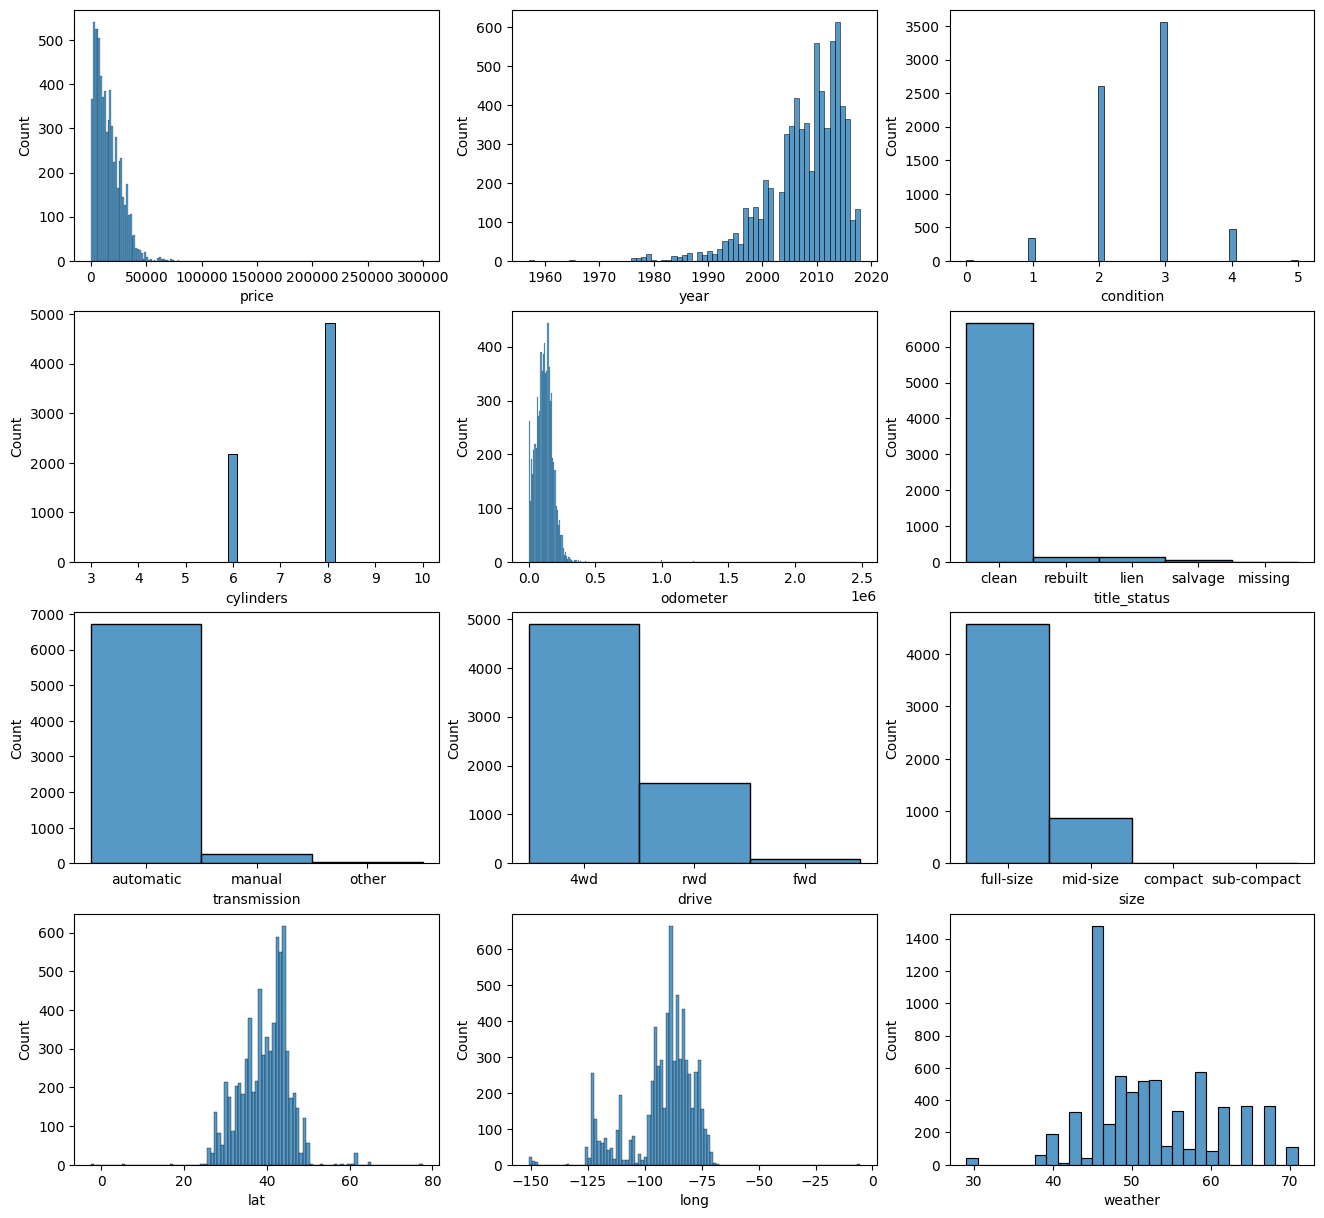

In [4]:
# Выделим названия признаков в отдельную переменную
cols_for_hist = data.columns
# Построим гистограммы частот значений в этих признаках
fig, axes = plt.subplots(4, 3, figsize=(16, 15))
feature_num = 0
for i in range(4):
    for j in range(3):
        sns.histplot(data[cols_for_hist[feature_num]], ax=axes[i][j])
        feature_num += 1

Как видим, нормального распределения значений ни в одном из признаков у нас не имеется: распределения числовых признаков ассиметричны, классы в категориальных признаках несбалансированы.

# Baseline model

In [5]:
# Напишем функцию для скорой перекодировки признаков в выборках
def encode_cat_features(columns_to_change, X_train, X_test, y_train):
    # Создадим кодировщик
    one_hot_encoder = OneHotEncoder()
    # Закодируем категориальные признаки (обучаем кодировщик только на тренировочной выборке)
    X_train_onehot = one_hot_encoder.fit_transform(X_train[columns_to_change]).toarray()
    X_test_onehot = one_hot_encoder.transform(X_test[columns_to_change]).toarray()
    # Для удобства сохраним полученные названия новых колонок в отдельную переменную
    columns = one_hot_encoder.get_feature_names_out(columns_to_change)
    # Результаты преобразуем обратно в DataFrame для удобства
    X_train_onehot_df = pd.DataFrame(X_train_onehot, columns=columns)
    X_test_onehot_df = pd.DataFrame(X_test_onehot, columns=columns)
    # Сбросим индексы таблиц
    X_train = X_train.reset_index().drop(['index'], axis = 1)
    X_test = X_test.reset_index().drop(['index'], axis = 1)
    y_train = y_train.reset_index().drop(['index'], axis = 1)
    # Добавим результаты кодирования к исходным таблицам
    X_train_new = pd.concat([X_train, X_train_onehot_df], axis=1)
    X_test_new = pd.concat([X_test, X_test_onehot_df], axis=1)
    # Удалим столбцы, которые уже были закодированы
    X_train_new = X_train_new.drop(columns=columns_to_change)
    X_test_new = X_test_new.drop(columns=columns_to_change)
    # Возвращаем новые трейн и тест выборки
    return X_train_new, X_test_new

# Напишем функцию для вывода метрик
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)), '\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))

Взглянем на результаты модели, обученной на данных вовсе без строк, содержащих пропуски.

In [6]:
# Разделим целевой и остальные признаки
y = data['price']
x = data.drop(columns='price')
# Удалим строки с пропусками
x = x.dropna()
y = y.iloc[x.index]
# Выведем размеры получившейся таблицы
print(x.shape)
# Сформируем выборки на основе очищенных данных
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=30
)
# Софрмируем список признаков для перекодировки
columns_to_change = ['cylinders', 'title_status', 'transmission', 'drive', 'size']
# Произведем перекодировку категориальных признаков 
X_train_new, X_test_new = encode_cat_features(columns_to_change, X_train, X_test, y_train)
# Выведем размеры таблиц выборок
print(X_train_new.shape, X_test_new.shape, '\n')
lr_model = LinearRegression()
lr_model.fit(X_train_new, y_train)
y_train_predict = lr_model.predict(X_train_new)
y_test_predict = lr_model.predict(X_test_new)
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

(5202, 11)
(4161, 27) (1041, 27) 

Train R^2: 0.647
Train MAE: 4403.622 

Test R^2: 0.693
Test MAE: 4138.175


Как можем видеть, линейная регрессия, обученная на укороченной версии данных, судя по значению коэффициента детерминации, уже позволяет создать приемлемую модель для предсказания цены авто. Данную модель мы возьмем за базовую. В дальнейшем мы постараемся добиться лучших результатов за счет предобработки данных.

# Заполнение пропусков с помощью ML

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         7017 non-null   int64  
 1   year          7017 non-null   int64  
 2   condition     7017 non-null   int64  
 3   cylinders     7017 non-null   int64  
 4   odometer      7017 non-null   int64  
 5   title_status  7017 non-null   object 
 6   transmission  7017 non-null   object 
 7   drive         6626 non-null   object 
 8   size          5453 non-null   object 
 9   lat           7017 non-null   float64
 10  long          7017 non-null   float64
 11  weather       6837 non-null   float64
dtypes: float64(3), int64(5), object(4)
memory usage: 658.0+ KB


Обычно пропуски заполняются средними/медианными/модальными значениями, однако большой минус таких методов в том, что они не учитывают корреляционную связь признака, содержащего пропуски, с остальными. Признаки, не имеющие NaN, можно использовать для прогнозирования пропущенных значений. Строится модель регрессии или классификации в зависимости от характера (категорийного или непрерывного) признака, имеющего пропущенное значение.

In [8]:
# Разделим целевой и остальные признаки
y = data['price']
x = data.drop(columns='price')

# Скопируем данные без целевого признака в отдельную переменную
df = x.copy()
 
# В качестве тестовой выборки возьмем строки с пропусками в признаке weather
test_data = df[df['weather'].isnull()]
# И удалим эти строчки из таблицы
df.dropna(inplace=True)

# Определим целевой признак и факторы
y_train = df['weather']
X_train = df.drop(['size','weather','drive'], axis=1)
X_test = test_data.drop(['size','weather','drive'], axis=1)

# Создадим список категориальных признаков
categorial_cols = ['cylinders', 'title_status', 'transmission']

# Получаем новые трейн и тест выборки
X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)

# Создадим модель линейной регрессии и обучим ее на задачу предсказания пропусков
model = LinearRegression()
model.fit(X_train_new, y_train)

# Сделаем предсказание целевой переменной (пропущенных значений в признаке weather) 
y_pred = model.predict(X_test_new)

Вставим найденную замену на место пропусков в столбце weather.

In [9]:
for i, ni in enumerate(test_data.index):
    x.loc[ni, 'weather'] = y_pred[i]

Проделаем все то же самое для признака size.

In [10]:
# Скопируем данные без целевого признака в отдельную переменную
df = x.copy()

# В качестве тестовой выборки возьмем строки с пропусками в признаке size
test_data = df[df['size'].isnull()]
# И удалим эти строчки из таблицы
df.dropna(inplace=True)

# Определим целевой признак и факторы
y_train = df['size']
X_train = df.drop(['size', 'drive'], axis=1)
X_test = test_data.drop(['size','drive'], axis=1)

# Получаем новые трейн и тест выборки
X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)

# Создадим модель линейной регрессии и обучим ее на задачу предсказания пропусков
model = LogisticRegression(max_iter=1000)
model.fit(X_train_new, y_train)

# Сделаем предсказание целевой переменной 
y_pred = model.predict(X_test_new)

# Вставим найденную замену на место пропусков
for i, ni in enumerate(test_data.index):
    x.loc[ni, 'size'] = y_pred[i]

И для drive.

In [11]:
# Скопируем данные без целевого признака в отдельную переменную
df = x.copy()

# В качестве тестовой выборки возьмем строки с пропусками в признаке drive
test_data = df[df['drive'].isnull()]
# И удалим эти строчки из таблицы
df.dropna(inplace=True)

# Определим целевой признак и факторы
y_train = df['drive']
X_train = df.drop(['drive'], axis=1)
X_test = test_data.drop(['drive'], axis=1)

# Создадим список категориальных признаков
categorial_cols = ['cylinders', 'title_status', 'transmission', 'size']

# Получаем новые трейн и тест выборки
X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)

# Создадим модель линейной регрессии и обучим ее на задачу предсказания пропусков
model = LogisticRegression(max_iter=1000)
model.fit(X_train_new, y_train)

# Сделаем предсказание целевой переменной 
y_pred = model.predict(X_test_new)

# Вставим найденную замену на место пропусков
for i, ni in enumerate(test_data.index):
    x.loc[ni, 'drive'] = y_pred[i]

In [12]:
# Взглянем на получившийся результат
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          7017 non-null   int64  
 1   condition     7017 non-null   int64  
 2   cylinders     7017 non-null   int64  
 3   odometer      7017 non-null   int64  
 4   title_status  7017 non-null   object 
 5   transmission  7017 non-null   object 
 6   drive         7017 non-null   object 
 7   size          7017 non-null   object 
 8   lat           7017 non-null   float64
 9   long          7017 non-null   float64
 10  weather       7017 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 603.1+ KB


Пропусков больше нет: мы заменили их на предсказанные значения. Насколько точно предсказанные - это еще вопрос: мы использовали дефолтные настройки моделей. Серьезная работа предполагает более тщательный подбор параметров также на этом этапе работы.

In [13]:
x.head()

,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.000000
1,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.000000
2,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.000000
3,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.000000
4,2010,3,8,166062,clean,automatic,4wd,full-size,49.210949,-123.114720,40.914356


Взглянем на модель, обученную на воссозданных данных.

In [14]:
# Софрмируем выборки
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=30
)

# Произведем перекодировку категориальных признаков 
X_train_new, X_test_new = encode_cat_features(columns_to_change, X_train, X_test, y_train)
# Выведем размеры таблиц
print(X_train_new.shape, X_test_new.shape, '\n')
# Обучаем подель, предсказываем цены и выводим метрики
lr_model = LinearRegression()
lr_model.fit(X_train_new, y_train)
y_train_predict = lr_model.predict(X_train_new)
y_test_predict = lr_model.predict(X_test_new)
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

(4911, 27) (2106, 27) 

Train R^2: 0.658
Train MAE: 4554.501 

Test R^2: 0.491
Test MAE: 4651.018


К сожалению, "восстановление" данных ощутимо ухудшило качество модели.

Но что получится, если мы отступим на шаг назад и пропсто заполним пропуски модами и средним значением (для категориальных и числового признака соответственно).

In [15]:
# Разделим целевой и остальные признаки
y = data['price']
x = data.drop(columns='price')
# Софрмируем выборки
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)
# Заполним округленными средними значениями пропуски в выборках признака weather
X_train['weather'] = X_train['weather'].fillna(np.round(np.mean(X_train['weather']),0))
X_test['weather'] = X_test['weather'].fillna(np.round(np.mean(X_train['weather']),0))
# Выведем значения категориальных признаков с самой большой долью
print(X_train['drive'].value_counts(True).head(1), '\n')
print(X_train['size'].value_counts(True).head(1))

4wd    0.738406
Name: drive, dtype: float64 

full-size    0.841164
Name: size, dtype: float64


In [16]:
# Заполняем пропуски в признаках модальными значениями
X_train['size'] = X_train['size'].fillna('full-size')
X_train['drive'] = X_train['drive'].fillna('4wd')
X_test['size'] = X_test['size'].fillna('full-size')
X_test['drive'] = X_test['drive'].fillna('4wd')

# Произведем перекодировку категориальных признаков
X_train_new, X_test_new = encode_cat_features(columns_to_change, X_train, X_test, y_train)

# Обучаем подель, предсказываем цены и выводим метрики
lr_model = LinearRegression()
lr_model.fit(X_train_new, y_train)
y_train_predict = lr_model.predict(X_train_new)
y_test_predict = lr_model.predict(X_test_new)
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.649
Train MAE: 4622.203 

Test R^2: 0.465
Test MAE: 4602.561


Модель оказалась еще хуже. Значит, заполнение пропусков с помощью ml не такое уж безнадежное дело, т.к. такой метод, разумеется, является более точным, чем заполнение пропусков значениями мер цетральных тенденций.

# Кодирование признаков

В наших данных присутствуют следующие категориальные признаки: condition, cylinders, title_status, transmission, drive, size. При этом, признаки condition и cylinders — числовые, а title_status, transmission, drive, size — текстовые.

Признак condition является порядковым, так как состояние машины 0 явно хуже состояния 5. Признак cylinders номинальный: в нём нет градации значений.

Важно производить кодирование номинальных признаков, даже если они уже представлены в числовом формате, так как, в отличие от порядковых признаков, категории номинальных являются независимыми. В случае порядкового кодирования таких признаков мы вносим искусственные закономерности в данные (например, чем больше числовой код цилиндров, тем лучше, хотя это необязательно так).

Посмотрим на число уникальных значений номинальных признаков title_status, transmission, drive, size и cylinders:

In [17]:
# Переназначим наши переменные
y = data['price']
x = data.drop(columns='price')
# Удалим строки с пропусками, т.к. манипуляции
# с пропущенными значениями себя не оправдали
x = x.dropna()
y = y.iloc[x.index]

for column in columns_to_change:
    print('Число уникальных значений признака {}: '.format(column), x[column].nunique())

Число уникальных значений признака cylinders:  6
Число уникальных значений признака title_status:  5
Число уникальных значений признака transmission:  3
Число уникальных значений признака drive:  3
Число уникальных значений признака size:  4


Итак, нам подходит однократное кодирование. Применим его к выбранным столбцам. Так как у нас нет отдельной тестовой выборки, то мы используем только один метод — fit_transform(). В качестве аргумента передаём таблицу с выбранными для преобразования признаками.

С помощью метода get_feature_names_out() получим список новых названий колонок:

In [18]:
# Создадим объект OneHotEncoder
one_hot_encoder = OneHotEncoder()

# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
data_onehot = one_hot_encoder.fit_transform(x[columns_to_change]).toarray() 
# запишем полученные названия новых колонок в отдельную переменную
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
print(column_names)

['cylinders_3' 'cylinders_4' 'cylinders_5' 'cylinders_6' 'cylinders_8'
 'cylinders_10' 'title_status_clean' 'title_status_lien'
 'title_status_missing' 'title_status_rebuilt' 'title_status_salvage'
 'transmission_automatic' 'transmission_manual' 'transmission_other'
 'drive_4wd' 'drive_fwd' 'drive_rwd' 'size_compact' 'size_full-size'
 'size_mid-size' 'size_sub-compact']


Отлично, категориальные признаки закодированы. Теперь нам необходимо соединить преобразованные данные с исходными.

In [19]:
# Преобразуем полученный массив закодированных данных в формат DataFrame, явно указав имена колонок
data_onehot = pd.DataFrame(data_onehot, index=x.index, columns=column_names)
# Соединим новую таблицу с исходной
x_new = pd.concat([x, data_onehot], axis=1)
# Удалим закодированные столбцы columns_to_change из полученной таблицы
x_new = x_new.drop(columns=columns_to_change)
# Выведем информацию о признаках новой таблицы
x_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5202 entries, 0 to 7016
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    5202 non-null   int64  
 1   condition               5202 non-null   int64  
 2   odometer                5202 non-null   int64  
 3   lat                     5202 non-null   float64
 4   long                    5202 non-null   float64
 5   weather                 5202 non-null   float64
 6   cylinders_3             5202 non-null   float64
 7   cylinders_4             5202 non-null   float64
 8   cylinders_5             5202 non-null   float64
 9   cylinders_6             5202 non-null   float64
 10  cylinders_8             5202 non-null   float64
 11  cylinders_10            5202 non-null   float64
 12  title_status_clean      5202 non-null   float64
 13  title_status_lien       5202 non-null   float64
 14  title_status_missing    5202 non-null   

Взглянем на предсказания модели.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=30)

# Обучаем подель, предсказываем цены и выводим метрики
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_train_predict = lr_model.predict(X_train)
y_test_predict = lr_model.predict(X_test)
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.643
Train MAE: 4464.983 

Test R^2: 0.685
Test MAE: 4210.217


Результаты чуть похуже, чем у базовой модели, но разницей можно пренебречь: она, видимо, обусловлена лишь порядком перекодирования.

Показания метрик все еще возможно улучшить путем предобработки данных: там могут содержаться выбросы, также значения признаков имеют разный масштаб, еще их распределения отличны от нормального, и возможно, учет моделью всех признаков не очень благоприятно сказывается на качестве прогноза: нужно еще провести отбор.

# Геоданные

Прежде чем приступить к манипуляциям со значеними признаков, посмотрим на то, как распределятся по карте мира имеющиеся у нас координаты.

Сперва мы взглянем на распределение координат исходного датасета, содержащего строки с пропусками. Затем воспользуемся текущим вариантом данных.

C:\Users\Il'naz\AppData\Local\Temp\ipykernel_9788\2594675417.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


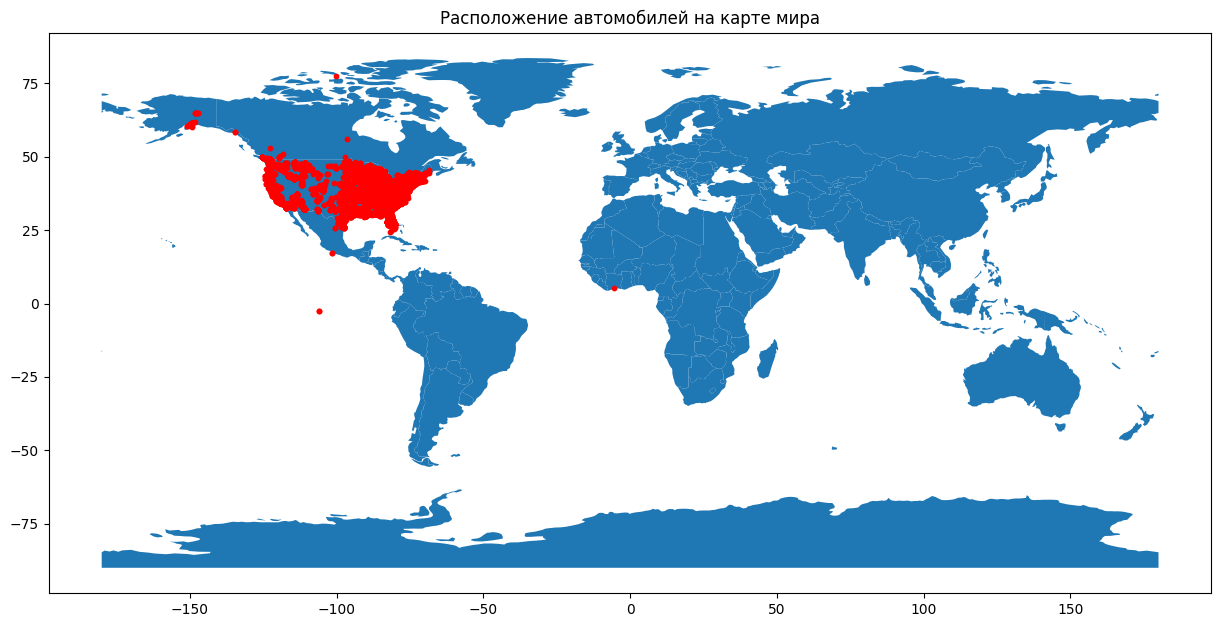

In [21]:
# Сформируем список координат
geometry = [Point(xy) for xy in zip(data['long'], data['lat'])]
# Создадим объект GeoDataFrame
gdf = GeoDataFrame(data, geometry=geometry)
# Подгрузим карту
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Добавим слой с маркерами
gdf.plot(ax=world.plot(figsize=(15, 15)), marker='o', color='red', markersize=10)
 
plt.title('Расположение автомобилей на карте мира')
plt.show();

C:\Users\Il'naz\AppData\Local\Temp\ipykernel_9788\4176518378.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


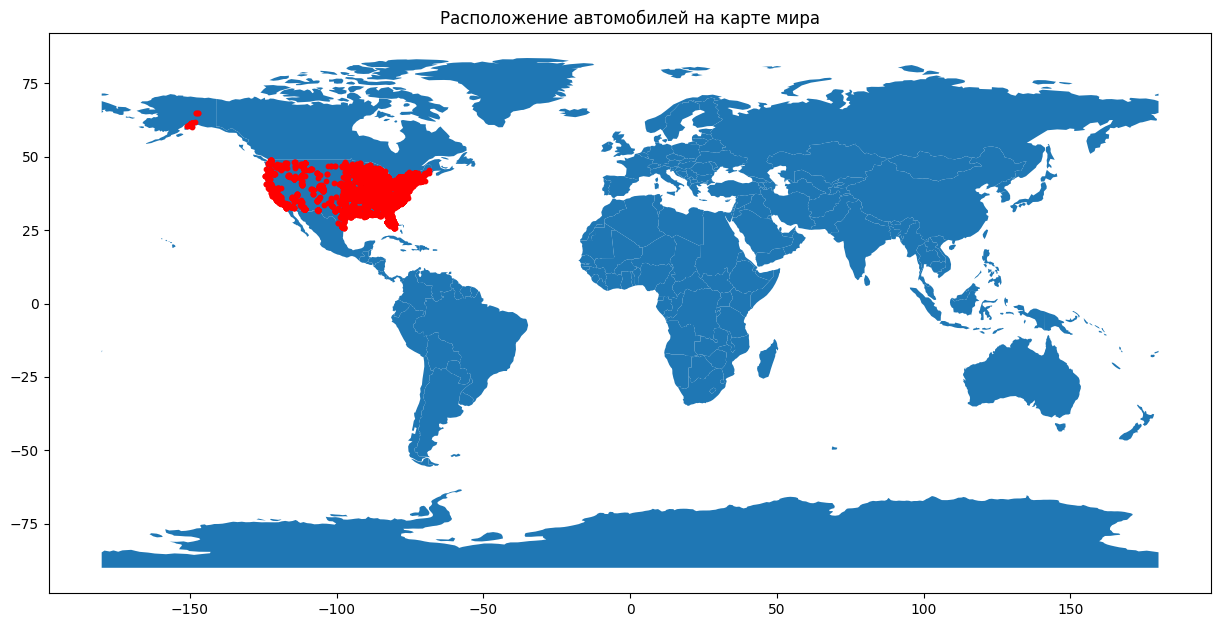

In [22]:
# Сформируем список координат
geometry = [Point(xy) for xy in zip(x_new['long'], x_new['lat'])]
# Создадим объект GeoDataFrame
gdf = GeoDataFrame(x_new, geometry=geometry)
# Подгрузим карту
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Добавим слой с маркерами
gdf.plot(ax=world.plot(figsize=(15, 15)), marker='o', color='red', markersize=10)
 
plt.title('Расположение автомобилей на карте мира')
plt.show();

Любопытно, мы лешились всех точек за пределами Штатов. Возможно, удаление строк с пропусками действительно имеет объективную пользу: мы снесли географические выбросы.

# Преобразование признаков

Еще раз взглянем на наши данные.

In [23]:
x_new.head(3)

,year,condition,odometer,lat,long,weather,cylinders_3,cylinders_4,cylinders_5,cylinders_6,...,transmission_automatic,transmission_manual,transmission_other,drive_4wd,drive_fwd,drive_rwd,size_compact,size_full-size,size_mid-size,size_sub-compact
0,2016,4,43500,36.471500,-82.483400,59.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2009,2,98131,40.468826,-74.281734,52.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2002,2,201803,42.477134,-82.949564,45.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


Нам осталось преобразовать признаки year, odometer, lat, long и weather - нормализуем их методом RobustScaler. А также прологарифмируем целевой признак price.

In [24]:
# Сбросим индексы
x_new.reset_index(drop=True, inplace=True)

# Копируем названия столбцов, которые теряются при использовании fit_transform()
col_names = ['year', 'odometer', 'lat', 'long', 'weather']

# Копируем названия остальных столбцов
other_col_names = [x_new.columns[1]] + list(x_new.columns[6:])
x_tail = x_new[other_col_names]

# Выделяем для преобразования часть таблицы
ftrs_for_prcssng = x_new[['year', 'odometer', 'lat', 'long', 'weather']]

# Инициализируем нормализатор RobustScaler
r_scaler = RobustScaler()
# Кодируем датасет
ftrs_trnsfrmd = r_scaler.fit_transform(ftrs_for_prcssng)

# Преобразуем промежуточный датасет в полноценный датафрейм
ftrs_trnsfrmd = pd.DataFrame(ftrs_trnsfrmd, columns=col_names)

# Пересоберем датасет с преобразованными признаками
x_new = pd.concat([ftrs_trnsfrmd, x_tail], axis=1)

# Взглянем на преобразованные признаки
x_new[['year', 'odometer', 'lat', 'long', 'weather']].head(3)

,year,odometer,lat,long,weather
0,0.750,-0.875150,-0.478161,0.465428,0.571429
1,-0.125,-0.207567,0.051729,1.149569,0.071429
2,-1.000,1.059291,0.317953,0.426543,-0.428571


Оценим влияние преобразований на качество модели.

In [25]:
# Сформируем выборки
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=30)

# Обучаем подель, предсказываем цены и выводим метрики
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_train_predict = lr_model.predict(X_train)
y_test_predict = lr_model.predict(X_test)
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.643
Train MAE: 4464.983 

Test R^2: 0.685
Test MAE: 4210.217


Результат остался тем же самым.

#  Отбор признаков

## Анализ корреляций

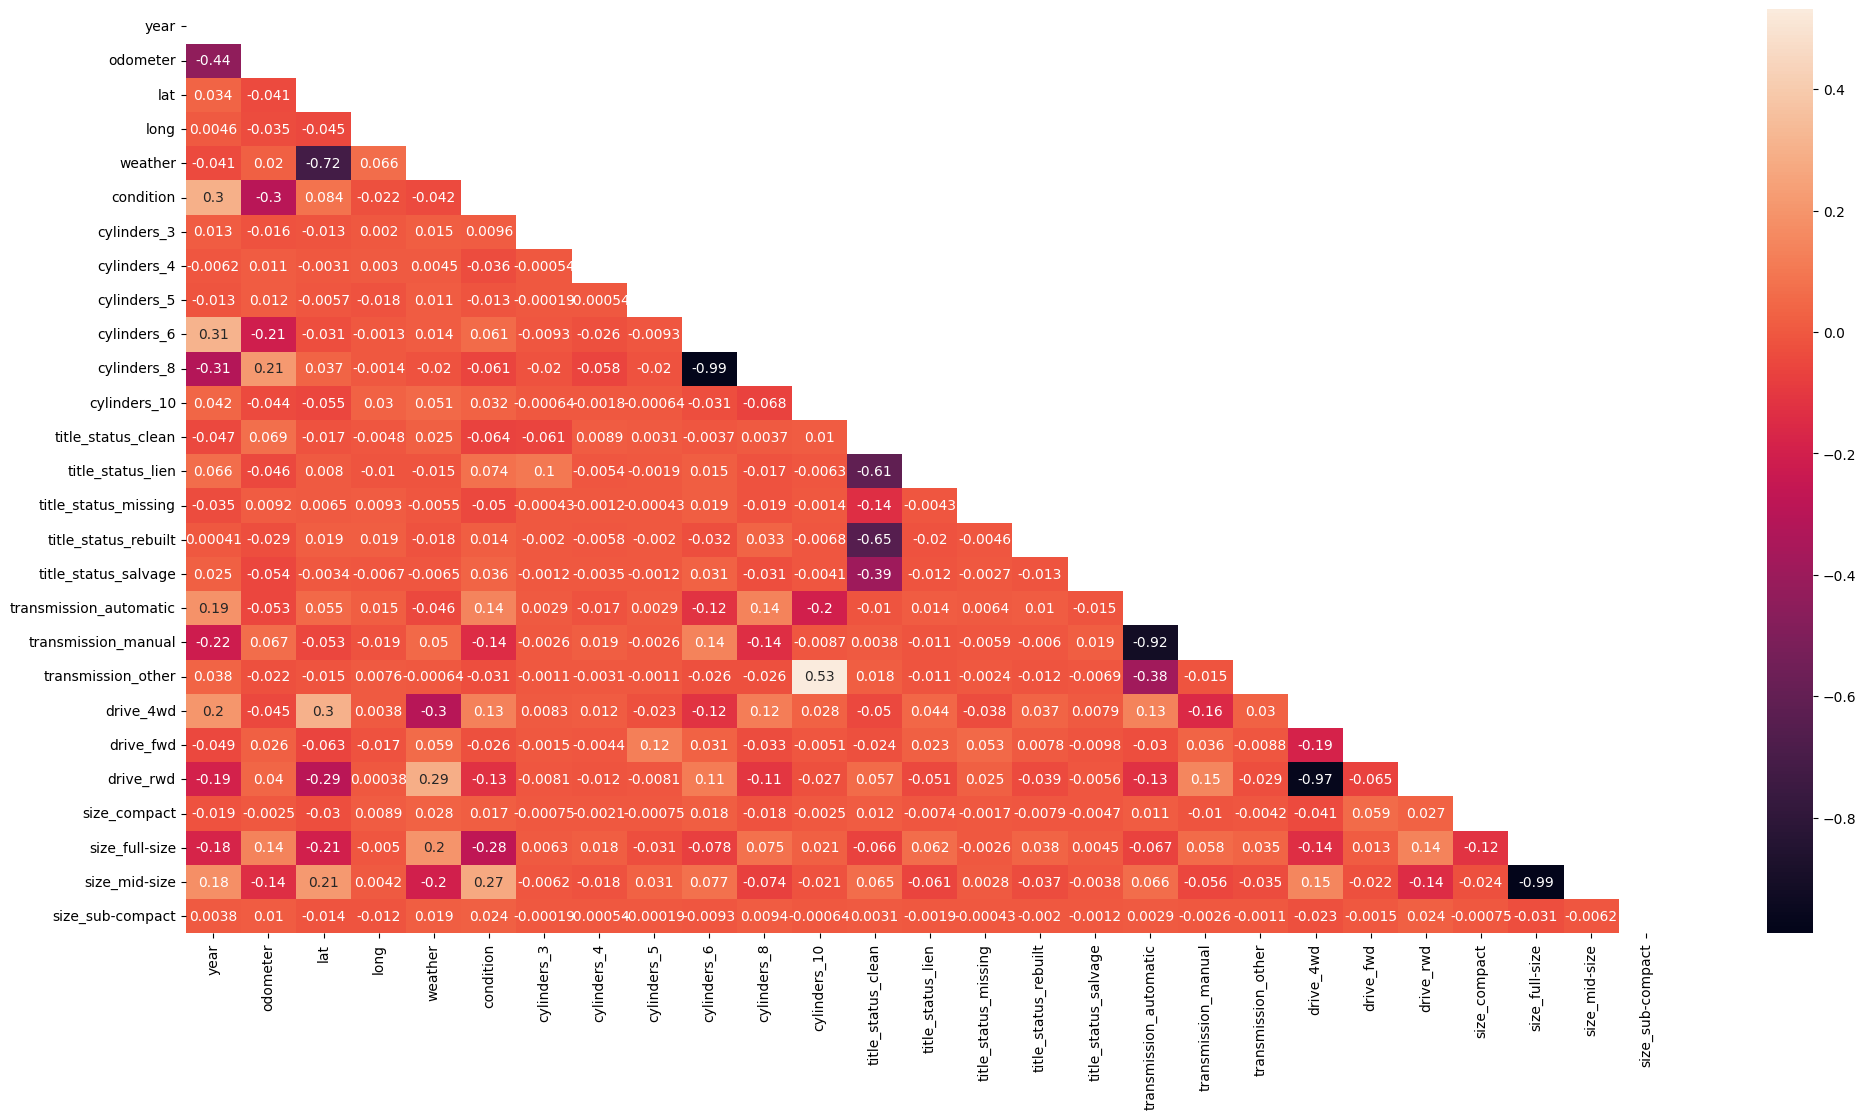

In [26]:
# Т.к. у нас есть категориальные признаки, мы используем корреляцию Кендала
x_new_corr = x_new.corr(method = 'kendall')
# Выведем тепловую карту на основе матрицы корреляций
matrix = np.triu(x_new_corr)
fig, axes = plt.subplots(figsize=(24, 12))
sns.heatmap(x_new_corr, annot=True, mask=matrix, ax=axes);

У нас, как видим, четыре избыточных признака, а также три пары сильно скореллированных признаков. Попробуем "вылечить" эту ситуацию удалением, и затем посмотрим, как это сказалось на качестве прогнозирования.

In [27]:
# Удаляем признаки с сильной корреляцией
x_ver1 = x_new.drop(columns=['lat', 'cylinders_6', 'title_status_clean',
                             'transmission_automatic', 'drive_4wd', 'size_full-size'])
# Формируем выборки
X_train, X_test, y_train, y_test = train_test_split(x_ver1, y, test_size=0.3, random_state=30)

# Обучаем подель, предсказываем цены и выводим метрики
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_train_predict = lr_model.predict(X_train)
y_test_predict = lr_model.predict(X_test)
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.642
Train MAE: 4461.027 

Test R^2: 0.686
Test MAE: 4203.199


Мы видим незначительное влияние на качество модели. Результат свидетельствует об очевидном: нет смысла обучать модель на всем объеме датасета, а от мультиколлениарностей стоит избавляться.

## Метод рекурсивного исключения признаков

In [28]:
# Формируем выборки
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=30)

# Назначаем оценщиком объект LinearRegression
estimator = LinearRegression()
# Нзаначаем селектором объект RFE
selector = RFE(
    estimator, # оценщик
    n_features_to_select=10, # количество признаков для отбора
    step=1 # число объектов удаляемых в каждой итерации
)
# Обучаем наш селектор
selector = selector.fit(X_train, y_train)
# Отправляем в список имена отобранных признаков
cols_ver2 = list(selector.get_feature_names_out())
print(cols_ver2)

['year', 'cylinders_3', 'cylinders_6', 'cylinders_10', 'title_status_clean', 'title_status_lien', 'transmission_manual', 'drive_4wd', 'size_mid-size', 'size_sub-compact']


Выведем полный перечень имеющихся признаков для сопоставления со списком рангов, которые селектор им присвоил.

In [29]:
X_train.columns

Index(['year', 'odometer', 'lat', 'long', 'weather', 'condition',
       'cylinders_3', 'cylinders_4', 'cylinders_5', 'cylinders_6',
       'cylinders_8', 'cylinders_10', 'title_status_clean',
       'title_status_lien', 'title_status_missing', 'title_status_rebuilt',
       'title_status_salvage', 'transmission_automatic', 'transmission_manual',
       'transmission_other', 'drive_4wd', 'drive_fwd', 'drive_rwd',
       'size_compact', 'size_full-size', 'size_mid-size', 'size_sub-compact'],
      dtype='object')

In [30]:
selector.ranking_

array([ 1,  3, 14, 18, 13,  5,  1,  4,  8,  1, 12,  1,  1,  1, 15,  7,  6,
       17,  1,  2,  1,  9, 16, 11, 10,  1,  1])

Селектор обозначил признак transmission_automatic как наименее ценный, присвоив ему ранг 22.

##  Метод выбора признаков на основе фильтров

В качестве фильтров для выбора признаков используются статистики: такие как коэффициент корреляции Пирсона, ANOVA и т. д. При этом выбор статистических показателей сильно зависит от типов переменных в данных.

In [31]:
# Назначаем селектором объект SelectKBest
# в качестве фильтра - коэффициент корреляции Пирсона
selector = SelectKBest(f_regression, k=10)
# Обучаем наш селектор
selector.fit(X_train, y_train)
# Отправляем в список имена отобранных признаков
cols_ver3 = list(selector.get_feature_names_out())
print(cols_ver3)

['year', 'odometer', 'condition', 'cylinders_6', 'cylinders_8', 'transmission_manual', 'drive_4wd', 'drive_rwd', 'size_full-size', 'size_mid-size']


In [32]:
print(set(cols_ver2) & set(cols_ver3))

{'cylinders_6', 'year', 'drive_4wd', 'transmission_manual', 'size_mid-size'}


Совпадает лишь половина отобранных селекторами признаков.

## Обучение моделей

Обучени линейной регрессии на признаках, найденных методом рекурсивного исключения.

In [33]:
# Отберем избранную часть датасета
x_ver2 = x_new[cols_ver2]
# Формируем выборки
X_train, X_test, y_train, y_test = train_test_split(x_ver2, y, test_size=0.3, random_state=30)

# Обучаем подель, предсказываем цены и выводим метрики
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_train_predict = lr_model.predict(X_train)
y_test_predict = lr_model.predict(X_test)
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.594
Train MAE: 4972.679 

Test R^2: 0.613
Test MAE: 4759.851


Обучени линейной регрессии на признаках, выбранных методом статистических фильтров.

In [34]:
# Отберем избранную часть датасета
x_ver3 = x_new[cols_ver3 ]
# Формируем выборки 
X_train, X_test, y_train, y_test = train_test_split(x_ver3, y, test_size=0.3, random_state=30)

# Обучаем подель, предсказываем цены и выводим метрики
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_train_predict = lr_model.predict(X_train)
y_test_predict = lr_model.predict(X_test)
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.633
Train MAE: 4542.981 

Test R^2: 0.675
Test MAE: 4270.235


Наилучший результат показал метод отбора признаков, основанный на статистических фильтрах. Показания метрик лишь незначительно отличаются от тех, что имеет базовая модель - и мы достигли такого результата обучив модель лишь на 10 признаках.

# Вывод

Нет сомнений, что мы можем перепрыгнуть нашу базовую модель, попытавшись использовать, например, алгоритм регрессии на градиентном спуске или полиномиальную регрессию, однако целью данной работы было именно рассмотрение методов предобработки данных. Да, наше их использование не очень хорошо отразилось на качестве модели, но в этом, скорее всего, нет вины самих методов: возможно, в этом плане наш выбор ml-алгоритма был неудачен, а возможно, нам просто не хватило времени, чтобы более вдумчиво использовать методы предобработки (было потрачено три дня неспешных манипуляций с кодом).

По результатам этот труд, боюсь, неудачен, а ценным является лишь сопутствовавший экспириенс автора, непосредственно измерить который никому из третьих лиц, вероятнее всего, не удастся (: